In [132]:
from mnist import MNIST 
import numpy as np
from pylab import *
from matplotlib import colors
%matplotlib inline

mndata = MNIST('./data')

mndata.load_training()
img_side = 28
n_mnist_pixels = img_side*img_side

In [133]:
labels = mndata.train_labels

cluster_size = 10
train_inputs_idx = []
for idx in [0, 4]:
    label_idx = np.where(np.isin(labels,[idx]))[0][:cluster_size]
    train_inputs_idx.append(label_idx)

samples_idx = np.array(train_inputs_idx, dtype='int').flatten()
samples_idx.size

20

In [134]:
images = []
for sample_idx in samples_idx.flatten():
    images.append(mndata.train_images[sample_idx])

images = np.array(images, dtype='float')
images = images / 255
images.shape

(20, 784)

In [135]:
def simple_plot(T: list):
    T_arr = np.array(T, dtype=float)

    fig, axs = plt.subplots(1, 1, figsize=(50, 5), tight_layout=True)
    axs.plot(np.arange(T_arr.size), T_arr)


    plt.show()

In [136]:
from typing import Literal

def show_image(image: ndarray, cmap: Literal['bone', 'Greys'] = 'bone'):
    # figure(figsize=(15, 10))

    imshow(np.array(image),
        interpolation='none',
        aspect='equal',
        cmap=cmap,
        )

    axis("off")

    show()

In [137]:
def get_discount_matrix(size):
    a = np.arange(size)
    a = np.abs(np.abs(a - a[np.newaxis].T) - np.max(a))
    np.fill_diagonal(a, 0)

    return a

In [138]:
def show_images_table(images_2d: ndarray, img_side: int = 28, row_size=10):
    column_size = int(images.shape[0] / row_size)

    shaped_images = images_2d.reshape(column_size, row_size, img_side, img_side)
    shaped_images = shaped_images.swapaxes(1, 2).reshape(column_size*img_side, row_size*img_side)

    figure(figsize=(15, 10))

    imshow(shaped_images,
           interpolation='none',
           aspect='equal',
           cmap='bone',
           )
    
    axis("off")

# show_images_table(images_2d=images)
images.shape

(20, 784)

In [139]:
def get_inhib_mask(size, inhib_prob = 0.2):
    c = []

    for i in range(size):
        c_row = np.random.choice([-1, 1], size=(size, ), p=[inhib_prob, 1.0 - inhib_prob])
        c.append(c_row)

    c = np.rot90(c)

    return np.array(c)

In [140]:
def infer(input: ndarray, W: ndarray, iter_cnt: int):
    I = np.copy(input)

    O = np.zeros(I.size)

    T = []
    OST = []

    for iter_idx in range(iter_cnt):
        DO = np.exp((I - W)**2 * -20.0)
        np.fill_diagonal(DO, 0)
        O += np.sum(DO, axis=1)

        O = O ** 2

        # inhibition
        O[np.where(O < np.mean(O))] = 0

        # recur
        O /= np.max(O)

        I = np.copy(O)

        # stats
        t = np.sum(O > 0)
        # t = np.mean(O)
        # t = np.sum(O)

        T.append(t)

        OST.append(np.copy(O))
    
    return T, OST


In [141]:
layer_size = n_mnist_pixels

I = np.zeros(n_mnist_pixels)
O = np.zeros(layer_size)
W = np.random.rand(O.size, I.size)
print('W', W.shape, W.max(), W.min(), np.median(W))

S0 = np.random.rand(O.size, I.size) * 0.01

HW = get_inhib_mask(I.size, inhib_prob = 0.5)

iter_cnt = 100

eps0_S = 0.01
eps_S = eps0_S

eps0 = 0.1

epoch_cnt = 100

SP = []
MP = []
CP = []
DP = []

# TODO: diff two digits?
# TODO: test on test images

for epoch_idx in range(epoch_cnt):
    eps = (epoch_cnt - epoch_idx) * eps0

    for img in images[:1]:
        I = np.copy(img)
        print(f'{I.shape=} {I.max()=} {I.min()=} {np.median(I)=}')

        OST = []

        last_iter = 0

        S = np.copy(S0)

        O.fill(0)

        for iter_idx in range(iter_cnt):
            eps_S = (iter_cnt - iter_idx) * eps0_S

            # infer
            SO = I * S
            DO = np.exp((SO - W)**2 * -20.0)
            DO *= HW
            np.fill_diagonal(DO, 0)
            dO = np.sum(DO, axis=1)
            # dO /= np.max(np.abs(dO))

            O += dO
            O[np.where(O < 0)] = 0
            
            # O = O ** 3

            # inhibition
            # O[np.where(O < np.mean(O))] = 0
            # O[np.where(O < 0)] = 0

            O /= np.max(O)

            # train S
            ddS = O * I[np.newaxis].T
            S += ddS * eps_S

            # stats
            prev_diff = np.abs(I - O).sum()
            SP.append(np.sum(O))
            # MP.append(np.mean(O))
            MP.append(prev_diff)
            CP.append(np.sum(O > 0))
            DP.append(np.sum(np.abs(SO - W) * (O > 0)[np.newaxis].T))

            OST.append(np.copy(O))

            last_iter += 1

            if prev_diff < 0.01:
                break

            # recur
            I = np.copy(O)

            max_S = np.max(S, axis=0)
            if np.max(max_S) > 1:
                S /= max_S

    # train
    thre = 0.3
    print(f'{thre=} {np.sum(O < thre)=}')

    # pos
    dW = (I - W)
    dW *= (O >= thre)[np.newaxis].T
    dW *= (O > 0)

    # neg
    dNW = (I - W)
    dNW *= (O < thre)[np.newaxis].T
    dNW *= (HW < 0)

    dW += dNW
    W += dW * eps0

    print('W', W.shape, W.max(), W.min(), np.median(W))
    print(f'{last_iter=}')
    print(f'{CP[-1]=}')

W (784, 784) 0.9999972755488357 4.723094202407907e-07 0.49963844388822404
I.shape=(784,) I.max()=1.0 I.min()=0.0 np.median(I)=0.0
thre=0.3 np.sum(O < thre)=657
W (784, 784) 0.9999937862739786 4.723094202407907e-07 0.48097937108198685
last_iter=73
CP[-1]=407
I.shape=(784,) I.max()=1.0 I.min()=0.0 np.median(I)=0.0
thre=0.3 np.sum(O < thre)=666
W (784, 784) 0.9999937862739786 4.723094202407907e-07 0.4613774849698572
last_iter=87
CP[-1]=317
I.shape=(784,) I.max()=1.0 I.min()=0.0 np.median(I)=0.0
thre=0.3 np.sum(O < thre)=666
W (784, 784) 0.9999937862739786 4.723094202407907e-07 0.4428597048386319
last_iter=47
CP[-1]=203
I.shape=(784,) I.max()=1.0 I.min()=0.0 np.median(I)=0.0
thre=0.3 np.sum(O < thre)=666
W (784, 784) 0.9999937862739786 4.723094202407907e-07 0.4245339945539457
last_iter=67
CP[-1]=125
I.shape=(784,) I.max()=1.0 I.min()=0.0 np.median(I)=0.0
thre=0.3 np.sum(O < thre)=672
W (784, 784) 0.9999937862739786 4.723094202407907e-07 0.40571004236347585
last_iter=47
CP[-1]=118
I.shape=(

CP[-1]=51


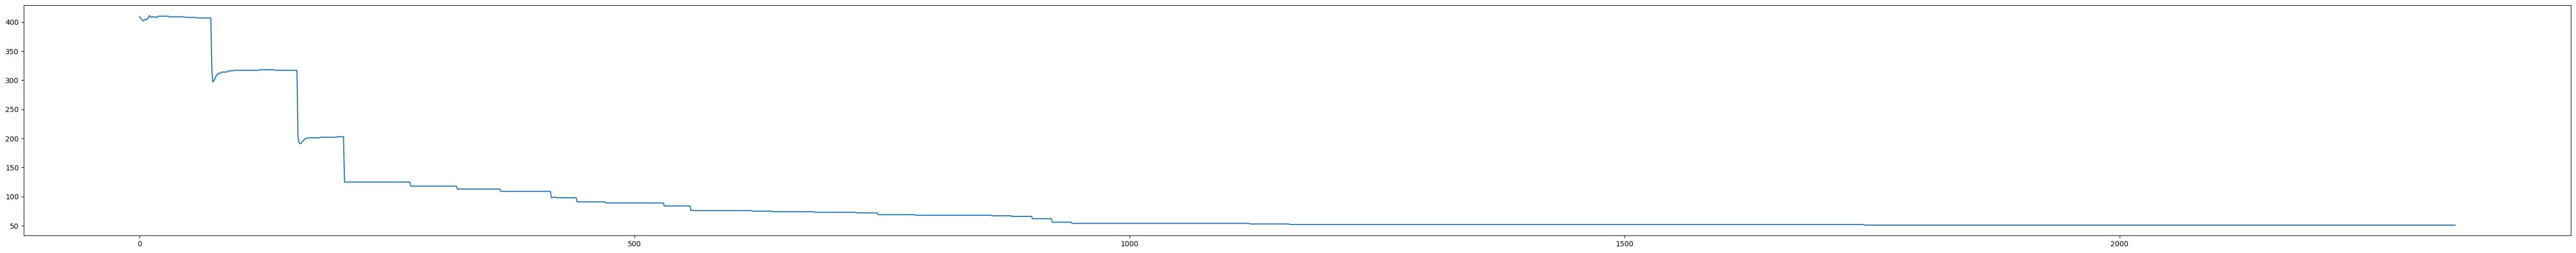

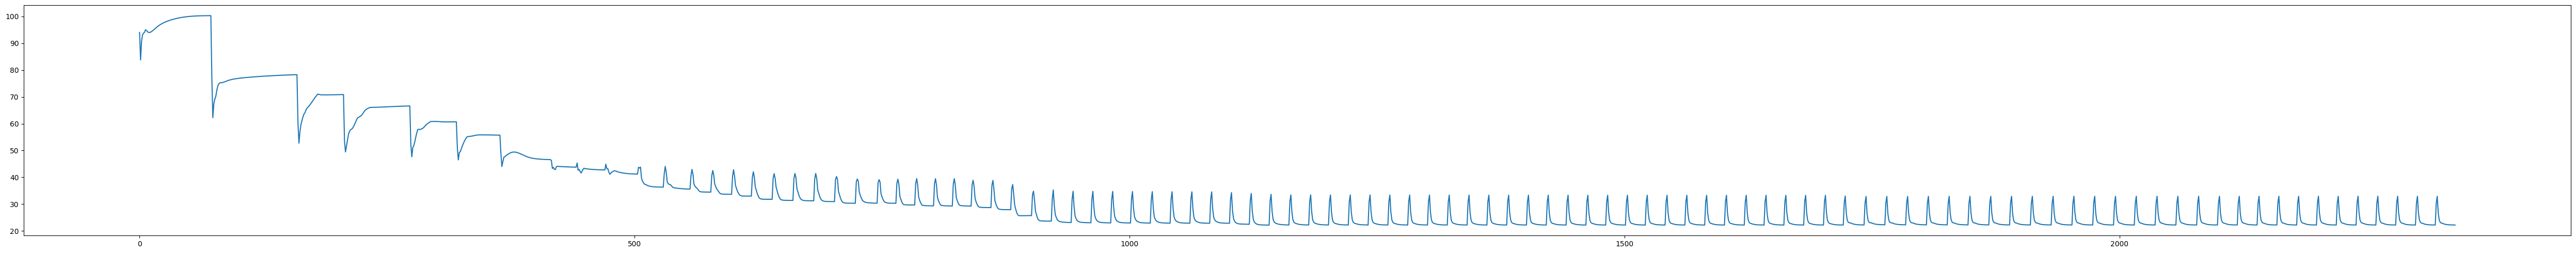

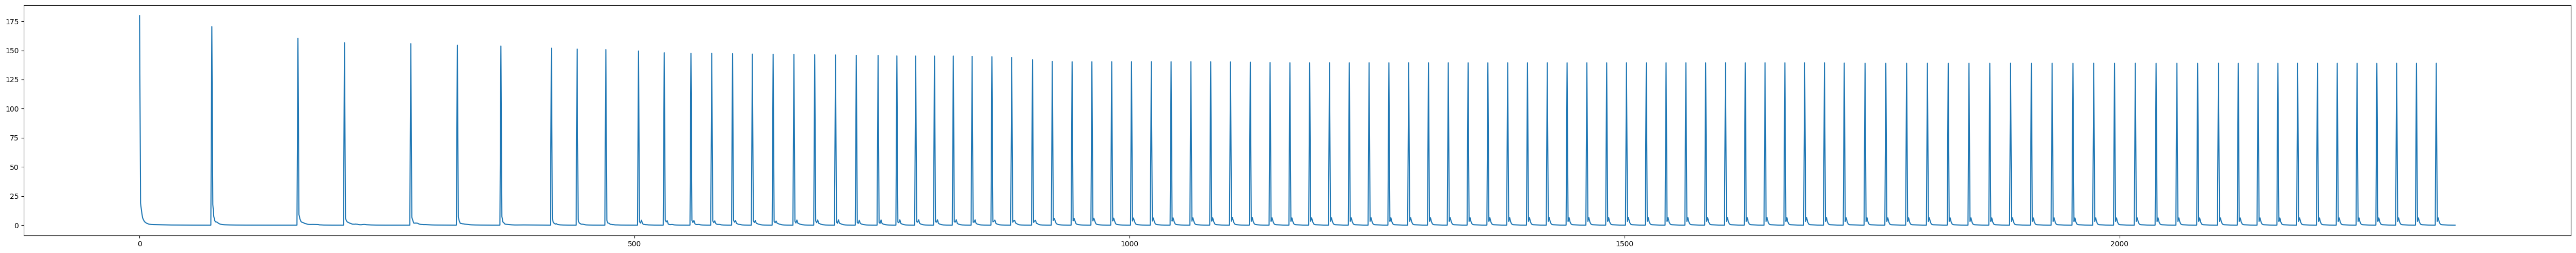

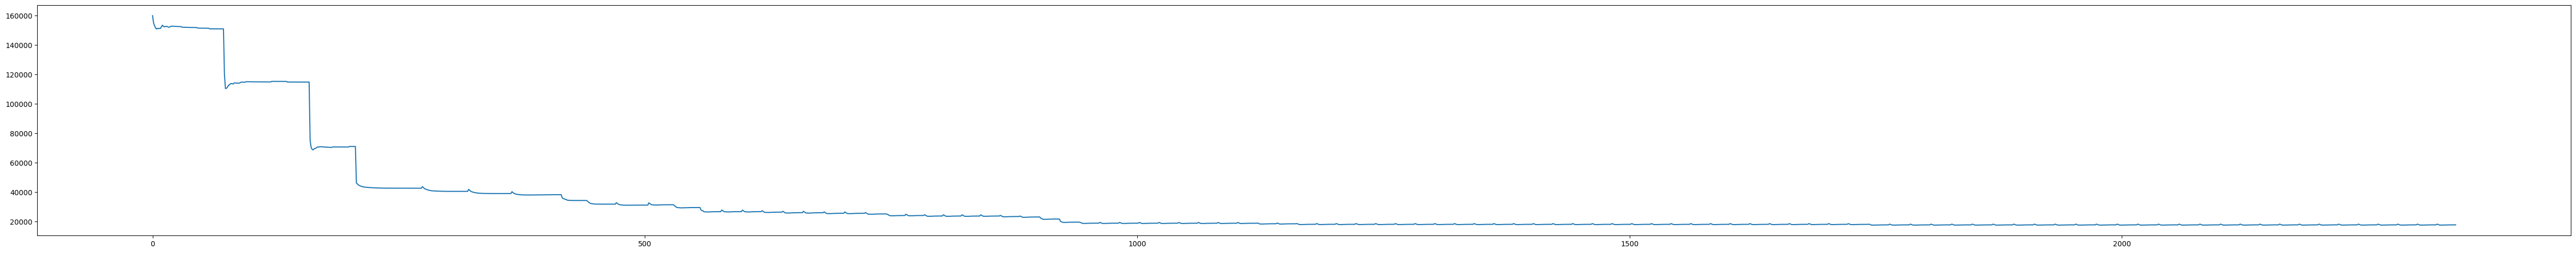

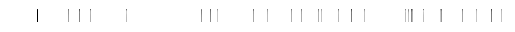

In [142]:
print(f'{CP[-1]=}')
simple_plot(T=CP)
simple_plot(T=SP)
simple_plot(T=MP)
simple_plot(T=DP)

show_image(image=OST, cmap='Greys')

In [143]:
MP[-10:]

[0.1387852155652191,
 0.09661413106211647,
 0.06810295192014376,
 0.049061795507699124,
 0.036070759347431036,
 0.027058777037816395,
 0.020625344262723833,
 0.0159145318522686,
 0.012420890382669025,
 0.00978784991271614]

i_T[-1]=455
i_T[:10]=[588, 410, 493, 427, 479, 450, 459, 458, 463, 451]


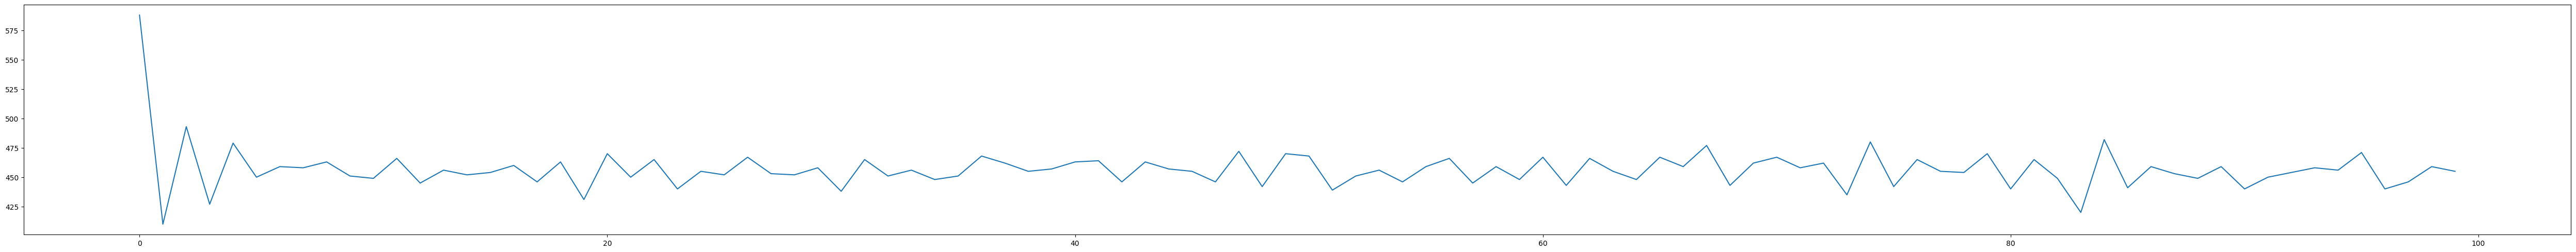

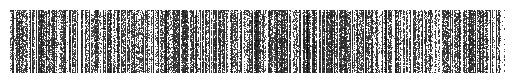

In [144]:
i_T, i_OST = infer(input=images[1], W=W, iter_cnt=iter_cnt)

print(f'{i_T[-1]=}')
print(f'{i_T[:10]=}')
simple_plot(T=i_T)

show_image(image=i_OST, cmap='Greys')

[[ 0 98 97 ...  2  1  0]
 [98  0 98 ...  3  2  1]
 [97 98  0 ...  4  3  2]
 ...
 [ 2  3  4 ...  0 98 97]
 [ 1  2  3 ... 98  0 98]
 [ 0  1  2 ... 97 98  0]]


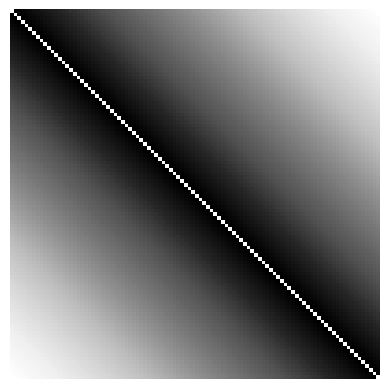

In [145]:
a = get_discount_matrix(100)
2 * a
print(a)
show_image(a, cmap='Greys')

[[ 1 -1 -1 ... -1  1  1]
 [-1  1  1 ... -1  1  1]
 [ 1  1 -1 ... -1  1  1]
 ...
 [-1  1 -1 ...  1  1  1]
 [-1 -1  1 ... -1 -1 -1]
 [ 1  1  1 ...  1 -1  1]]


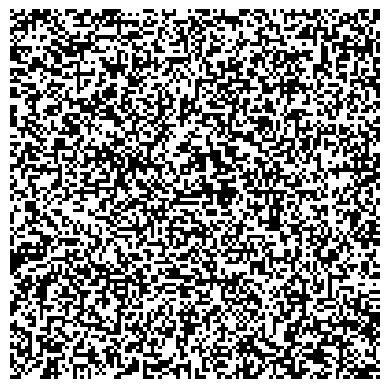

In [146]:
c = get_inhib_mask(100, 0.5)

print(c)
show_image(c, cmap='Greys')